# Performance Tuning and Optimization in PySpark


This notebook consolidates techniques for performance tuning and optimization in PySpark. It includes examples and explanations for:
- Analyzing Query Plans
- Understanding and Optimizing DAGs
- Implementing Partitioning and Bucketing
- Exploring caching


#Analyzing Query plans

Spark query plans are crucial for understanding how Spark executes your queries. They provide insights into the operations performed, data shuffling, and overall execution strategy.
Analyzing the query plan helps identify performance bottlenecks and optimize queries.

Narrow vs. Wide Transformations

- Narrow transformations: Operations that can be performed within a single partition.  They do not involve data shuffling across partitions.
Examples: `filter`, `map`, `flatMap`. These are generally faster because no data movement occurs.


- Wide transformations: Operations that require data shuffling across partitions. Data is reorganized based on the transformation.
Examples: `groupBy`, `join`, `distinct`, `coalesce`, `repartition`. These are often slower than narrow transformations due to data movement.



Wide Transformations:

Repartition:  Increases or decreases the number of partitions. It always involves a full shuffle of the data, which can be expensive. Useful when you need to increase parallelism or reduce the number of partitions for subsequent operations. Use with care.
  - If you repartition to a larger number of partitions than you have data, some partitions may be empty.
  - If the data is highly skewed, it can lead to uneven partition sizes.

Coalesce: Reduces the number of partitions without a full shuffle if possible.  Tries to combine existing partitions, therefore it’s more efficient than `repartition` in most cases. However, it is limited to reducing the number of partitions.
  - It can often avoid shuffling and thus provides significant performance benefits.
  - Suitable when the number of partitions needs to be decreased without causing data rebalancing.

Joins: Combine rows from two or more DataFrames or Datasets based on a join condition.
  - Join types:  Inner, outer (left, right, full), semi, anti.
  - Different join types have varying performance characteristics.
  - Joins are often wide transformations, especially when the join key is not evenly distributed.  This is because the data needs to be shuffled so that rows with the same join key are in the same partition.
  - Consider the size of your tables; for smaller ones, broadcasting (making one dataset available to all partitions of the other) might be a better option to reduce data shuffling.
  - Optimize join keys for uniform distribution to minimize data movement.


GroupBy: Groups data based on the values of one or more columns.
  - Followed by aggregation operations such as `count`, `sum`, `mean`, `min`, `max`.
  - It requires a shuffle to bring rows with the same group key together in the same partition.


Aggregations (`count`, `countDistinct`, `sum`)
- Count: Determines the number of rows in a DataFrame or Dataset.
  - Can be optimized if it follows a filter or a narrow transformation.


- CountDistinct: Computes the number of distinct values in a column or a group.
  - Expensive as it involves a shuffle.
  - Consider using `approx_count_distinct` for large datasets.


- Sum: Calculates the sum of values in a column or group.
  -  Usually less computationally expensive than `countDistinct`.

Example:
Let's say you have a large dataset of sales transactions partitioned by date.

1. Filtering for a specific date range (narrow transformation)
2. Grouping by product category (wide transformation - shuffle required)
3. Calculating the total sales for each category (aggregation - occurs after shuffle)
4. Sorting the results by total sales (wide transformation - shuffle required).

In this case, the `groupBy` and sort operations are wide transformations, while the initial filter is a narrow transformation. The performance of the query is greatly influenced by these wide transformations.  Minimizing shuffles (using coalesce, better join methods, and careful choice of partitions) is key.

Spark Query Plans

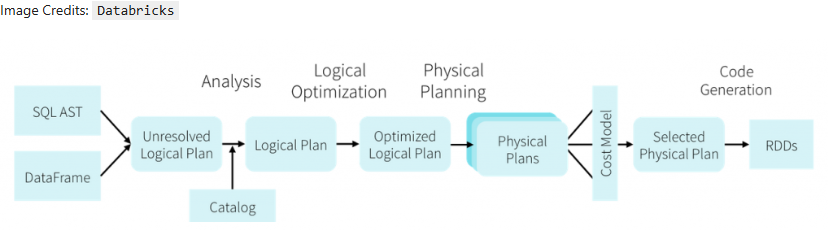

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("QualityOfService5GQueryAnalysis") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

In [ ]:
# Step 2: Read the CSV file
file_path = "/content/Quality of Service 5G.csv"
data = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

In [ ]:
# Display schema for verification
data.printSchema()
data.show(5, truncate=False)

# Step 3: Analyze query plan for a sample transformation
# Applying a transformation (e.g., filtering and selecting specific columns)
# Replace 'some_column_name', 'some_value', 'column1', and 'column2'
# with actual column names and values from your DataFrame
filtered_data = data.filter(col("Application_Type") == "Video Streaming").select("Latency", "Allocated_Bandwidth")

root
 |-- Timestamp: string (nullable = true)
 |-- User_ID: string (nullable = true)
 |-- Application_Type: string (nullable = true)
 |-- Signal_Strength: string (nullable = true)
 |-- Latency: string (nullable = true)
 |-- Required_Bandwidth: string (nullable = true)
 |-- Allocated_Bandwidth: string (nullable = true)
 |-- Resource_Allocation: string (nullable = true)

+--------------+-------+-----------------+---------------+-------+------------------+-------------------+-------------------+
|Timestamp     |User_ID|Application_Type |Signal_Strength|Latency|Required_Bandwidth|Allocated_Bandwidth|Resource_Allocation|
+--------------+-------+-----------------+---------------+-------+------------------+-------------------+-------------------+
|9/3/2023 10:00|User_1 |Video_Call       |-75 dBm        |30 ms  |10 Mbps           |15 Mbps            |70%                |
|9/3/2023 10:00|User_2 |Voice_Call       |-80 dBm        |20 ms  |100 Kbps          |120 Kbps           |80%                

In [ ]:
# Show the query plan for the transformation
print("Logical Query Plan:")
filtered_data.explain(mode="formatted")

# Step 4: Analyze the query DAG
# Perform an action to trigger DAG creation (e.g., count)
print("Triggering action to analyze the query DAG:")
filtered_data.count()

Logical Query Plan:
== Physical Plan ==
* Project (3)
+- * Filter (2)
   +- Scan csv  (1)


(1) Scan csv 
Output [3]: [Application_Type#749, Latency#751, Allocated_Bandwidth#753]
Batched: false
Location: InMemoryFileIndex [file:/content/Quality of Service 5G.csv]
PushedFilters: [IsNotNull(Application_Type), EqualTo(Application_Type,Video Streaming)]
ReadSchema: struct<Application_Type:string,Latency:string,Allocated_Bandwidth:string>

(2) Filter [codegen id : 1]
Input [3]: [Application_Type#749, Latency#751, Allocated_Bandwidth#753]
Condition : (isnotnull(Application_Type#749) AND (Application_Type#749 = Video Streaming))

(3) Project [codegen id : 1]
Output [2]: [Latency#751, Allocated_Bandwidth#753]
Input [3]: [Application_Type#749, Latency#751, Allocated_Bandwidth#753]


Triggering action to analyze the query DAG:


0

In [ ]:
# Display the DAG visualization
print("DAG Visualization:")
spark.sparkContext.uiWebUrl

# Step 5: Save the transformed data (optional)
output_path = "/mnt/data/output/QualityOfService5G_transformed"
filtered_data.write.mode("overwrite").option("header", "true").csv(output_path)

DAG Visualization:


'http://f5228187a93c:4040'


#Bucketing in Spark

Purpose:Bucketing in Spark is a data partitioning technique that distributes data across multiple files based on a specified set of columns (bucketing columns).  This improves join performance significantly by reducing data shuffling.  When joining two bucketed tables on the bucketed columns, Spark can avoid expensive shuffles as data with the same bucket key will reside on the same executor, enabling efficient local joins.

Mechanism:

- Hashing: Spark applies a hash function to the bucketing columns of each row.  The hash function's output determines the bucket to which the row belongs.  The number of buckets is pre-defined when creating or repartitioning the table.

- Data Distribution: Rows with the same hash value (and hence the same bucket key) are written to the same file within the directory of the bucketed table.  This co-location of related data across different files is the key to performance gains.

- Join Optimization: When joining two bucketed tables on the same bucketing columns, Spark can optimize the join operation.  If both tables are bucketed on the join keys and have the same number of buckets, the join can be performed locally on each executor, drastically reducing data shuffling.

Benefits:

- Improved Join Performance: The primary benefit of bucketing. Local joins eliminate or greatly reduce shuffling, leading to significantly faster execution times.
- Optimized Data Locality: Related data is grouped together, improving data locality and reducing I/O operations.
- Efficient Aggregation: Bucketing can also be beneficial for aggregation operations where the grouping columns are the same as the bucketing columns.
- Reduced Shuffling Overhead: Less data movement across the cluster due to the pre-partitioned nature of bucketed tables.

Considerations:

Choosing Bucketing Columns: Selecting appropriate bucketing columns is crucial.  These should be the columns frequently used in join operations. The number of distinct values in the bucketing columns determines the effectiveness of bucketing.  Too few distinct values may lead to very large buckets and less efficiency, whereas too many might lead to overly fine-grained partitioning.

- Number of Buckets: The number of buckets should be a multiple of the number of Spark executors to maximize parallelism and avoid skewness. It must also be configured in both the tables being joined for effective optimization.

- Data Skewness: Bucketing can still be impacted by data skewness.  If certain buckets contain disproportionately large amounts of data, it may negatively affect performance. Skewness could be mitigated using techniques such as salted bucketing.

- Storage Overhead: Bucketing can increase storage overhead because files are created for each bucket.

- Overheads for Non-bucketed Data: Bucketing does not affect non-bucketed tables during joins and still requires shuffles and may not improve performance.

Overall bucketing is a powerful technique in Spark for improving the performance of join and aggregation operations.  Properly choosing the bucketing columns and the number of buckets is key to its effectiveness.  Be aware of potential skew and use salted bucketing if necessary.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
from pyspark.storagelevel import StorageLevel
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

In [ ]:
spark = (
    SparkSession
    .builder
    .config("spark.driver.memory", "10g")
    .master("local[*]")
    .getOrCreate()
)
sc = spark.sparkContext
sc.setLogLevel("ERROR")
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [ ]:
data_file = "/content/Quality of Service 5G.csv"
df_orders = spark.read.csv(data_file, header=True, inferSchema=True)

In [ ]:
df_orders.show(5, False)
df_orders.printSchema()

+--------------+-------+-----------------+---------------+-------+------------------+-------------------+-------------------+
|Timestamp     |User_ID|Application_Type |Signal_Strength|Latency|Required_Bandwidth|Allocated_Bandwidth|Resource_Allocation|
+--------------+-------+-----------------+---------------+-------+------------------+-------------------+-------------------+
|9/3/2023 10:00|User_1 |Video_Call       |-75 dBm        |30 ms  |10 Mbps           |15 Mbps            |70%                |
|9/3/2023 10:00|User_2 |Voice_Call       |-80 dBm        |20 ms  |100 Kbps          |120 Kbps           |80%                |
|9/3/2023 10:00|User_3 |Streaming        |-85 dBm        |40 ms  |5 Mbps            |6 Mbps             |75%                |
|9/3/2023 10:00|User_4 |Emergency_Service|-70 dBm        |10 ms  |1 Mbps            |1.5 Mbps           |90%                |
|9/3/2023 10:00|User_5 |Online_Gaming    |-78 dBm        |25 ms  |2 Mbps            |3 Mbps             |85%          

In [ ]:
synth_file = "/content/synthetic_telecom_dataset (1).csv"
df_products = spark.read.csv(synth_file, header=True, inferSchema=True)

In [ ]:
df_products.show(5, False)
df_products.printSchema()

+-------+--------+---------+--------+-------+------+------+------------+------------+-----------------+------------------+--------------------+------------------+------------------+---------------------+------------------+--------------------+-----------------+-----------------+-----------+----------+
|TowerID|Location|Operator |Band    |Traffic|Uptime|Faults|Faults_Class|Uptime_Class|Traffic_per_Fault|Downtime          |Fault_Severity_Index|Log_Traffic       |Log_Downtime      |Log_Traffic_per_Fault|Uptime_Traffic    |Traffic_per_Downtime|Traffic_Squared  |Uptime_Squared   |Traffic_Bin|Uptime_Bin|
+-------+--------+---------+--------+-------+------+------+------------+------------+-----------------+------------------+--------------------+------------------+------------------+---------------------+------------------+--------------------+-----------------+-----------------+-----------+----------+
|1      |West    |Operator2|800 MHz |72.53  |94.71 |2     |High        |Low Uptime  |36.265

In [ ]:
df_products.select("Location").distinct().count()

6

In [ ]:
df_orders.select("User_ID").distinct().count()

400

## Bucketing In Joins

In [ ]:
df_orders_product_details = (
    df_orders.join(
        df_products,
        on=df_orders["User_ID"] == df_products["Band"], # Assuming 'Band' in df_products corresponds to 'User_ID' in df_orders
        how="inner"
    )
)

In [ ]:
df_orders_product_details.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [User_ID#18], [Band#95], Inner
   :- Sort [User_ID#18 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(User_ID#18, 200), ENSURE_REQUIREMENTS, [plan_id=254]
   :     +- Filter isnotnull(User_ID#18)
   :        +- FileScan csv [Timestamp#17,User_ID#18,Application_Type#19,Signal_Strength#20,Latency#21,Required_Bandwidth#22,Allocated_Bandwidth#23,Resource_Allocation#24] Batched: false, DataFilters: [isnotnull(User_ID#18)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/Quality of Service 5G.csv], PartitionFilters: [], PushedFilters: [IsNotNull(User_ID)], ReadSchema: struct<Timestamp:string,User_ID:string,Application_Type:string,Signal_Strength:string,Latency:str...
   +- Sort [Band#95 ASC NULLS FIRST], false, 0
      +- Exchange hashpartitioning(Band#95, 200), ENSURE_REQUIREMENTS, [plan_id=255]
         +- Filter isnotnull(Band#95)
            +- FileScan csv [TowerID#92,Location#93,Opera

In [ ]:
df_orders_product_details.count()

0

In [ ]:
(
    df_products
    .write.bucketBy(4, col="TowerID") # Changed 'product_id' to 'TowerID'
    .mode("overwrite")
    .saveAsTable("products_bucketed")
)

In [ ]:
(
    df_orders
    .write.bucketBy(4, col="User_ID") # Changed 'product_id' to 'User_ID' as it exists in the df_orders DataFrame
    .mode("overwrite")
    .saveAsTable("orders_bucketed")
)

In [ ]:
df_orders_bucketed = spark.table("orders_bucketed")
df_products_bucketed = spark.table("products_bucketed")

In [ ]:
df_orders_product_details_bucketed = (
    df_orders_bucketed.join(
        df_products_bucketed,
        on=df_orders_bucketed["User_ID"] == df_products_bucketed["Band"], # Assuming 'Band' in df_products corresponds to 'User_ID' in df_orders_bucketed
        how="inner"
    )
)

In [ ]:
df_orders_product_details_bucketed.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [User_ID#439], [Band#457], Inner
   :- Sort [User_ID#439 ASC NULLS FIRST], false, 0
   :  +- Filter isnotnull(User_ID#439)
   :     +- FileScan parquet spark_catalog.default.orders_bucketed[Timestamp#438,User_ID#439,Application_Type#440,Signal_Strength#441,Latency#442,Required_Bandwidth#443,Allocated_Bandwidth#444,Resource_Allocation#445] Batched: true, Bucketed: true, DataFilters: [isnotnull(User_ID#439)], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/content/spark-warehouse/orders_bucketed], PartitionFilters: [], PushedFilters: [IsNotNull(User_ID)], ReadSchema: struct<Timestamp:string,User_ID:string,Application_Type:string,Signal_Strength:string,Latency:str..., SelectedBucketsCount: 4 out of 4
   +- Sort [Band#457 ASC NULLS FIRST], false, 0
      +- Exchange hashpartitioning(Band#457, 4), ENSURE_REQUIREMENTS, [plan_id=533]
         +- Filter isnotnull(Band#457)
            +- FileScan parquet spark

In [ ]:
df_orders_product_details_bucketed.count()

0

## Bucketing In Aggregations

In [ ]:
df_orders.show(5, False)

+--------------+-------+-----------------+---------------+-------+------------------+-------------------+-------------------+
|Timestamp     |User_ID|Application_Type |Signal_Strength|Latency|Required_Bandwidth|Allocated_Bandwidth|Resource_Allocation|
+--------------+-------+-----------------+---------------+-------+------------------+-------------------+-------------------+
|9/3/2023 10:00|User_1 |Video_Call       |-75 dBm        |30 ms  |10 Mbps           |15 Mbps            |70%                |
|9/3/2023 10:00|User_2 |Voice_Call       |-80 dBm        |20 ms  |100 Kbps          |120 Kbps           |80%                |
|9/3/2023 10:00|User_3 |Streaming        |-85 dBm        |40 ms  |5 Mbps            |6 Mbps             |75%                |
|9/3/2023 10:00|User_4 |Emergency_Service|-70 dBm        |10 ms  |1 Mbps            |1.5 Mbps           |90%                |
|9/3/2023 10:00|User_5 |Online_Gaming    |-78 dBm        |25 ms  |2 Mbps            |3 Mbps             |85%          

In [ ]:
# Assuming 'Application_Type' is the closest proxy for 'product_id'
df_product_sales = (
    df_orders
    .groupBy("Application_Type")  # Changed 'product_id' to 'Application_Type'
    .agg(F.sum("Allocated_Bandwidth").alias("sales"))  # Changed 'total_amount' to 'Allocated_Bandwidth' as it exists in the df_orders DataFrame
)

df_product_sales.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[Application_Type#19], functions=[sum(cast(Allocated_Bandwidth#23 as double))])
   +- Exchange hashpartitioning(Application_Type#19, 200), ENSURE_REQUIREMENTS, [plan_id=731]
      +- HashAggregate(keys=[Application_Type#19], functions=[partial_sum(cast(Allocated_Bandwidth#23 as double))])
         +- FileScan csv [Application_Type#19,Allocated_Bandwidth#23] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/Quality of Service 5G.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Application_Type:string,Allocated_Bandwidth:string>




In [ ]:
# WITH BUCKETING

# Assuming 'Application_Type' and 'Allocated_Bandwidth' are the correct columns for bucketed aggregation
df_product_sales = (
    df_orders_bucketed
    .groupBy("Application_Type")  # Replace 'product_id' with 'Application_Type'
    .agg(F.sum("Allocated_Bandwidth").alias("sales"))  # Replace 'total_amount' with 'Allocated_Bandwidth'
)

df_product_sales.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[Application_Type#440], functions=[sum(cast(Allocated_Bandwidth#444 as double))])
   +- Exchange hashpartitioning(Application_Type#440, 200), ENSURE_REQUIREMENTS, [plan_id=744]
      +- HashAggregate(keys=[Application_Type#440], functions=[partial_sum(cast(Allocated_Bandwidth#444 as double))])
         +- FileScan parquet spark_catalog.default.orders_bucketed[Application_Type#440,Allocated_Bandwidth#444] Batched: true, Bucketed: false (bucket column(s) not read), DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/content/spark-warehouse/orders_bucketed], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Application_Type:string,Allocated_Bandwidth:string>




## Bucket Pruning

In [ ]:
df_product_sales_bucket_pruning = (
    df_orders_bucketed
    .filter(F.col("Application_Type") == 1)  # Changed 'product_id' to 'Application_Type'
    .groupBy("Application_Type")  # Changed 'product_id' to 'Application_Type'
    .agg(F.sum("Allocated_Bandwidth").alias("sales"))  # Changed 'total_amount' to 'Allocated_Bandwidth'
)

In [ ]:
df_product_sales_bucket_pruning.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[Application_Type#440], functions=[sum(cast(Allocated_Bandwidth#444 as double))])
   +- Exchange hashpartitioning(Application_Type#440, 200), ENSURE_REQUIREMENTS, [plan_id=763]
      +- HashAggregate(keys=[Application_Type#440], functions=[partial_sum(cast(Allocated_Bandwidth#444 as double))])
         +- Filter (isnotnull(Application_Type#440) AND (cast(Application_Type#440 as int) = 1))
            +- FileScan parquet spark_catalog.default.orders_bucketed[Application_Type#440,Allocated_Bandwidth#444] Batched: true, Bucketed: false (bucket column(s) not read), DataFilters: [isnotnull(Application_Type#440), (cast(Application_Type#440 as int) = 1)], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/content/spark-warehouse/orders_bucketed], PartitionFilters: [], PushedFilters: [IsNotNull(Application_Type)], ReadSchema: struct<Application_Type:string,Allocated_Bandwidth:string>




## What Problems Does Partitioning Solve?
1. `Fast Search (Query Performance)`: Spark will only process the relevant partition instead of the entire dataset (example above). This greatly reduces I/O and query execution time.
2. `Parallelism / Resource Utilization`: Each core processes 1 partition; More number of partitions, more is the parallelism; again this does not mean we forcefully increase the number of partitions. Each partition should be `128MB` in size.


# Partitioning Examples
1. Single/multi level partitioning
2. Using `repartition`/`coalesce` with `partitionBy` (controlling number of files inside each partition):
    - `parititionBy` affects how data is laid out in the storage and is going to ensure that the output directory is organized into subdirectories based on the `value` given in `partitionBy`.  
    - Number of files in each `value` directory of `partitionBy` depends on the number supplied in the `repartition`/`coalesce`.

# Dynamic Partitioning Pruning
- Pruning partitions at runtime
- Problem Statement: Analyse the listening activity of users on the release date of a song on/after `2020-01-01`

In [ ]:
# Path to the dataset
file_path = "/content/telecom_segmentation_data (1).xlsx"

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Dynamic Partitioning and Pruning") \
    .config("spark.sql.dynamicPartitionPruning.enabled", "true") \
    .getOrCreate()

In [ ]:
!pip install openpyxl
!pip install pyspark==3.4.1 # install pyspark
!pip install spark-excel # This installs the necessary library

# Import necessary libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col

# Path to the dataset
file_path = "/content/telecom_segmentation_data (1).xlsx"

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Dynamic Partitioning and Pruning") \
    .config("spark.sql.dynamicPartitionPruning.enabled", "true") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.6") \
    .getOrCreate()

# Load the dataset
df = spark.read.format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_path)

# Show the schema and preview the data
df.printSchema()
df.show(5)

ERROR: Could not find a version that satisfies the requirement spark-excel (from versions: none)
ERROR: No matching distribution found for spark-excel
root
 |-- Customer_ID: double (nullable = true)
 |-- Monthly_Bill_Amount: double (nullable = true)
 |-- Average_Call_Duration: double (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Data_Usage_GB: double (nullable = true)
 |-- Number_of_Calls: double (nullable = true)
 |-- Customer_Tenure: double (nullable = true)

+-----------+-------------------+---------------------+---------+-----------------+---------------+---------------+
|Customer_ID|Monthly_Bill_Amount|Average_Call_Duration|  Segment|    Data_Usage_GB|Number_of_Calls|Customer_Tenure|
+-----------+-------------------+---------------------+---------+-----------------+---------------+---------------+
|        1.0|  45.09054491313347|                  2.0|Low Usage|19.35246582352076|          118.0|            9.0|
|        2.0|  46.92616129684993|    2.757929853910177

In [ ]:
# Write data to a partitioned Parquet table
df.write \
    .partitionBy("Segment") \
    .mode("overwrite") \
    .parquet("/content/telecom_partitioned")

# Simulate a query with dynamic partition pruning
# Scenario: Retrieve data for customers with specific Segments
segments_to_query = ["Low Usage", "High Usage"]

# Filter for the specific segments
filtered_df = spark.read.parquet("/content/telecom_partitioned").filter(col("Segment").isin(segments_to_query))

# Show the filtered results
filtered_df.show()

+-----------+-------------------+---------------------+-----------------+---------------+---------------+----------+
|Customer_ID|Monthly_Bill_Amount|Average_Call_Duration|    Data_Usage_GB|Number_of_Calls|Customer_Tenure|   Segment|
+-----------+-------------------+---------------------+-----------------+---------------+---------------+----------+
|      201.0|  166.6011356924932|                  9.0| 32.4595506615601|          177.0|            5.0|High Usage|
|      202.0|  165.0635851232038|    9.957319005471525|5.122858284757393|          179.0|            4.0|High Usage|
|      203.0|  155.7691020981043|     9.73624804282397|8.919806990636076|          146.0|            8.0|High Usage|
|      204.0|  175.2989049990153|    13.87596427863489|45.02915523782688|          187.0|            6.0|High Usage|
|      205.0|  169.6573185547206|    14.10036945271318|30.71502392331991|           36.0|            2.0|High Usage|
|      206.0|  173.8821763877986|    16.84366312153884|1.4506555

In [ ]:
# 1. Aggregate data for each segment
aggregated_df = filtered_df.groupBy("Segment").agg(
    F.avg("Monthly_Bill_Amount").alias("Avg_Monthly_Bill"),  # Changed 'avg' to 'F.avg'
    F.max("Monthly_Bill_Amount").alias("Max_Monthly_Bill"),
    F.min("Monthly_Bill_Amount").alias("Min_Monthly_Bill"),
    F.count("Customer_ID").alias("Customer_Count")
)

In [ ]:
# Show aggregated data
aggregated_df.show()

+----------+-----------------+-----------------+-----------------+--------------+
|   Segment| Avg_Monthly_Bill| Max_Monthly_Bill| Min_Monthly_Bill|Customer_Count|
+----------+-----------------+-----------------+-----------------+--------------+
|High Usage|150.7079654870629|177.5919410430558| 124.002445417083|           100|
| Low Usage|35.29216763332163|49.39026748983255|21.34808924668906|           100|
+----------+-----------------+-----------------+-----------------+--------------+



In [ ]:
# 2. Top customers by data usage in each segment
top_customers_df = filtered_df.orderBy(col("Data_Usage_GB").desc()).limit(10)

In [ ]:
# Show top customers
top_customers_df.show()

+-----------+-------------------+---------------------+-----------------+---------------+---------------+----------+
|Customer_ID|Monthly_Bill_Amount|Average_Call_Duration|    Data_Usage_GB|Number_of_Calls|Customer_Tenure|   Segment|
+-----------+-------------------+---------------------+-----------------+---------------+---------------+----------+
|      262.0|   138.646528153986|   -1.157660248587199| 49.5126386551089|          127.0|            6.0|High Usage|
|       70.0|  31.68340188226425|   -7.582680935234436|49.35745989342535|          189.0|            2.0| Low Usage|
|      227.0|  149.4257464714745|    16.22331462656009|48.67751718286983|          176.0|            1.0|High Usage|
|       12.0|  38.30509180614585|    4.773301315544028|48.52558275593772|          133.0|            8.0| Low Usage|
|       51.0|  31.92155656587763|    1.902278152636217|48.50964676046337|           95.0|            1.0| Low Usage|
|      248.0|  137.7964966937485|     10.9526986229373|48.366086

In [ ]:
# 3. Analyze call durations by segment
call_duration_analysis = filtered_df.groupBy("Segment").agg(
    F.avg("Average_Call_Duration").alias("Avg_Call_Duration"), # Changed 'avg' to 'F.avg' to use the PySpark function
    F.max("Average_Call_Duration").alias("Max_Call_Duration"), # Changed 'max' to 'F.max' to use the PySpark function
    F.min("Average_Call_Duration").alias("Min_Call_Duration")  # Changed 'min' to 'F.min' to use the PySpark function
)

In [ ]:
# Show call duration analysis
call_duration_analysis.show()

+----------+------------------+-----------------+------------------+
|   Segment| Avg_Call_Duration|Max_Call_Duration| Min_Call_Duration|
+----------+------------------+-----------------+------------------+
|High Usage| 7.961133210370124|35.72230202774152|-16.14389950902911|
| Low Usage|1.7177211164734245|16.12217120449789|-12.11350593110357|
+----------+------------------+-----------------+------------------+



# Caching in Spark

Caching in Spark is a crucial optimization technique that significantly improves performance by storing intermediate datasets in memory or on disk.  This prevents redundant computations, especially in iterative algorithms or when the same dataset is accessed multiple times.

## How Caching Works

When you cache a DataFrame or RDD, Spark stores the data in memory across the executors in your cluster.  Subsequent actions on the cached data retrieve it directly from memory, eliminating the need to recompute it from the source.  This dramatically reduces execution time and network I/O.

## When to Use Caching

Caching is most beneficial when:

* **Iterative Algorithms:**  Algorithms that repeatedly process the same data (e.g., machine learning algorithms, graph processing) benefit greatly from caching.
* **Frequently Accessed Data:** If a DataFrame or RDD is used in multiple transformations or actions within your application, caching it avoids recomputation.
* **Large Datasets:**  While caching can improve performance for smaller datasets, its impact is most pronounced with large datasets where recomputation is expensive.

## Persistence Levels

Spark provides several persistence levels, allowing you to control where and how the data is cached:

* **MEMORY_ONLY:** Stores the data in memory.  If the data doesn't fit in memory, some partitions may be evicted. This is the default persistence level.
* **MEMORY_AND_DISK:** Stores the data in memory.  If the data doesn't fit in memory, the overflow is spilled to disk.
* **MEMORY_ONLY_SER:** Stores the data in memory in serialized form.  This uses less memory but requires deserialization before use, which adds a small overhead.
* **MEMORY_AND_DISK_SER:** Stores the data in memory in serialized form. If it doesn't fit, the overflow goes to disk.
* **DISK_ONLY:** Stores the data only on disk.
* **MEMORY_ONLY_2, MEMORY_AND_DISK_2:** Same as MEMORY_ONLY and MEMORY_AND_DISK, but replicates each partition across two nodes for fault tolerance.
* **OFF_HEAP:** Stores data off-heap, which can be beneficial in some memory-constrained environments.

The choice of persistence level depends on the available memory, the frequency of access, and the size of the data.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

In [5]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Caching Example with Dataset") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [6]:
# Load the dataset into a DataFrame
data_path = "/content/network_slicing_recognition.csv"
df = spark.read.option("header", "true").option("inferSchema", "true").csv(data_path)

In [7]:
df.show()

+---------------+----+----------------+------------+---+------+---+-------+------------+----------+------------+-----------+-------------+-----------------+--------------------+----------+----------+
|LTE/5g Category|Time|Packet Loss Rate|Packet delay|IoT|LTE/5G|GBR|Non-GBR|AR/VR/Gaming|Healthcare|Industry 4.0|IoT Devices|Public Safety|Smart City & Home|Smart Transportation|Smartphone|slice Type|
+---------------+----+----------------+------------+---+------+---+-------+------------+----------+------------+-----------+-------------+-----------------+--------------------+----------+----------+
|             14|   0|          1.0E-6|          10|  1|     0|  0|      1|           0|         0|           0|          0|            1|                0|                   0|         0|         3|
|             18|  20|           0.001|         100|  0|     1|  1|      0|           1|         0|           0|          0|            0|                0|                   0|         0|         1|


In [8]:
# Perform initial transformations
# Filter rows where 'Packet Loss Rate' > 0.001 and select relevant columns
filtered_df = df.filter(col("Packet Loss Rate") > 0.001).select(
    "LTE/5g Category", "Time", "Packet Loss Rate", "Packet delay", "slice Type"
)

In [9]:
# Cache the filtered DataFrame
filtered_df.cache()

DataFrame[LTE/5g Category: int, Time: int, Packet Loss Rate: double, Packet delay: int, slice Type: int]

In [10]:
# Perform actions on the cached DataFrame
# Count the number of rows in the filtered DataFrame
row_count = filtered_df.count()
print(f"Row count after filtering: {row_count}")

Row count after filtering: 8869


In [11]:
# Displaying a sample of the cached DataFrame
filtered_df.show(10)

+---------------+----+----------------+------------+----------+
|LTE/5g Category|Time|Packet Loss Rate|Packet delay|slice Type|
+---------------+----+----------------+------------+----------+
|              3|  17|            0.01|         100|         1|
|              9|   4|            0.01|          50|         2|
|             15|   2|            0.01|         300|         2|
|              7|   3|            0.01|          50|         2|
|              1|  16|            0.01|          75|         1|
|             20|  18|            0.01|         100|         1|
|             19|   5|            0.01|         100|         1|
|              9|  17|            0.01|          50|         2|
|              6|   1|            0.01|          75|         1|
|             17|  21|            0.01|         100|         1|
+---------------+----+----------------+------------+----------+
only showing top 10 rows



In [12]:
# Unpersisting the DataFrame to release memory
filtered_df.unpersist()

DataFrame[LTE/5g Category: int, Time: int, Packet Loss Rate: double, Packet delay: int, slice Type: int]

In [13]:
# stopping the SparkSession
spark.stop()

Use .cache() to store the DataFrame in memory and potentially on disk.
This avoids recomputing the DataFrame every time it's used in subsequent actions.

- Triggering Cache:
The .cache() operation is lazy. An action like .count() or .show() is needed to materialize the cache.

- Unpersisting:
Call .unpersist() to release memory when the cached data is no longer needed.